In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import typing

In [ ]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving flower.jpg to flower (3).jpg


**a.**

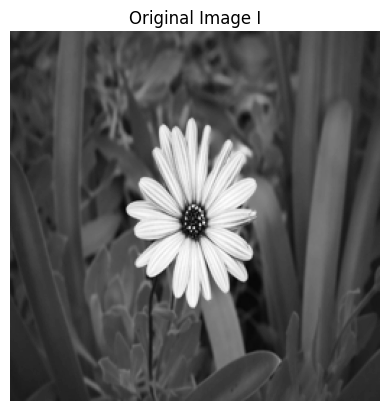

In [ ]:
# Open image as gray scale
image = Image.open(filename).convert('L')  # Convert to grayscale
image = image.resize((256,256))
# Convert to numpy array
image_array = np.array(image)

# Normalize to [0, 1]
image_normalized = image_array / 255.0

plt.imshow(image_normalized, cmap='gray')
plt.title("Original Image I")
plt.axis('off')
plt.show()

In [ ]:
def random_create_r(frequency_k: float, n=256):
  A_vector= np.random.normal(loc=0.1, scale=1/20.0, size=(n,1))
  phi_vector = np.random.uniform(low=0.0, high = 2*np.pi, size=(n,1))
  matrix =  np.tile(np.arange(1, n + 1), (256,1))
  matrix = 2*np.pi*frequency_k* matrix
  matrix = matrix + phi_vector
  return A_vector * np.cos(matrix), A_vector, phi_vector

def show_image(image, title):
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.title(title)
  plt.show()


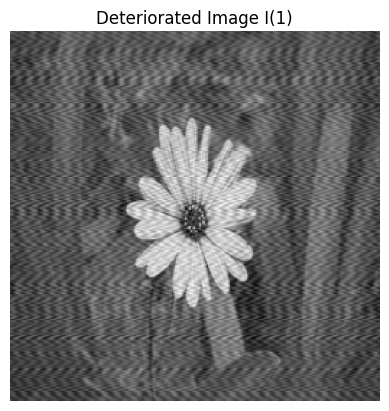

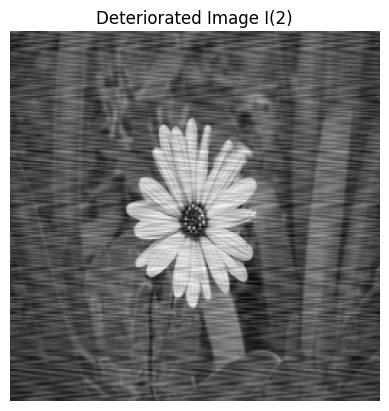

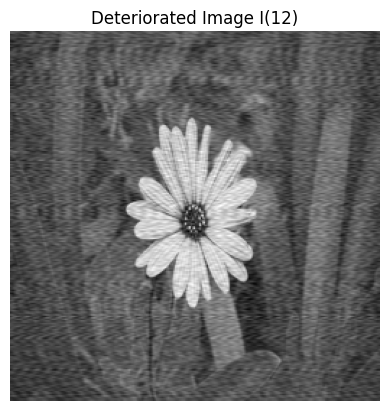

In [ ]:
r_1, A_1, phi_1 = random_create_r(frequency_k=1/8.0)
r_2, A_2, phi_2 = random_create_r(frequency_k=1/32.0)
r_12 = (r_1 + r_2) /2.0

I_1 = image_normalized + r_1
I_2 = image_normalized + r_2
I_12 = image_normalized + r_12


show_image(I_1, "Deteriorated Image I(1)")
show_image(I_2, "Deteriorated Image I(2)")
show_image(I_12, "Deteriorated Image I(12)")

**b,c,d**

In [ ]:
import numpy as np
import math

def create_dft_matrix(N):
    # Create a grid of indices
    k = np.arange(N).reshape((N, 1))
    n = np.arange(N).reshape((1, N))
    indicies_matrix = k*n # broadcasting
    W = np.exp(-2j*np.pi*indicies_matrix /N)

    # Normalize by sqrt(N) to make the matrix unitary
    W /= np.sqrt(N)
    return W

def empiric_dft_transform(image):

  assert(image.shape[0] == image.shape[1])

  DFT = create_dft_matrix(image.shape[0])

  image_numpy = np.array(image)


  transformed =np.dot(image, DFT)
  return transformed


def dft_theory_transform_noise(amplitude, phase, frequency, n):
    assert(math.floor(n*frequency)== math.ceil(n*frequency))
    q = int(frequency * n)
    # Harmonic noise contribution
    e_q = np.zeros(n, dtype=complex)
    e_n_q = np.zeros(n, dtype=complex)

    e_q[q % n] = 1  # Basis vector at q mod n
    e_n_q[(n - q) % n] = 1  # Basis vector at (n - q) mod n

    noise_component = (amplitude * np.sqrt(n) / 2) * (np.exp(1j * phase) * e_q + np.exp(-1j * phase) * e_n_q)
    return noise_component

import numpy as np
import math

def dft_theory_transform_image(original_image_dft, frequency, amplitudes, phases):
    assert(original_image_dft.shape[0] == original_image_dft.shape[1])
    n = original_image_dft.shape[0]
    transformed_image = np.zeros((n, n), dtype=complex)

    for i in range(n):
        amplitude = amplitudes[i]
        phase = phases[i]
        # Compute the theoretical noise component for the row
        noise_component = dft_theory_transform_noise(amplitude, phase, frequency, n).reshape(1,-1)
        transformed_image[i, :] = noise_component

    return transformed_image+original_image_dft

def dft_theory_transform_image_weighted_average(original_image_dft, frequency_1, frequency_2, w1,w2, amplitudes_1, phases_1,amplitudes_2, phases_2):
    assert(original_image_dft.shape[0] == original_image_dft.shape[1])
    n = original_image_dft.shape[0]
    transformed_image = np.zeros((n, n), dtype=complex)

    for i in range(n):
        amplitude_1 = amplitudes_1[i]
        phase_1 = phases_1[i]
        amplitude_2 = amplitudes_2[i]
        phase_2 = phases_2[i]
        # Compute the theoretical noise component for the row
        noise_component_1 = dft_theory_transform_noise(amplitude_1, phase_1, frequency_1, n).reshape(1,-1)
        noise_component_2 = dft_theory_transform_noise(amplitude_2, phase_2, frequency_2, n).reshape(1,-1)
        transformed_image[i, :] = (w1*noise_component_1+w2*noise_component_2)/(w1+w2)

    return transformed_image+original_image_dft

In [ ]:
def log_transform_and_normalize(dft_result):
    magnitude_spectrum = np.abs(dft_result)
    log_magnitude_spectrum = np.log(1 + magnitude_spectrum)
    normalized_spectrum = (log_magnitude_spectrum - log_magnitude_spectrum.min()) / \
                          (log_magnitude_spectrum.max() - log_magnitude_spectrum.min())
    return normalized_spectrum

def show_image_dft(image, title):
  res = log_transform_and_normalize(image)
  plt.imshow(res, cmap='gray')
  plt.title(title)
  plt.show()


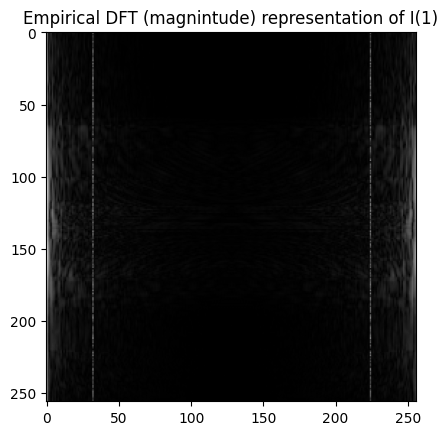

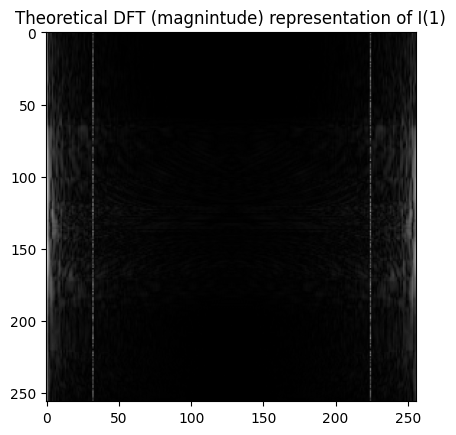

In [ ]:
original_image_dft = empiric_dft_transform(image_normalized)

I1_empirical = empiric_dft_transform(I_1)


I1_theory =  dft_theory_transform_image(original_image_dft, 1/8.0, A_1, phi_1)


show_image_dft(I1_empirical, "Empirical DFT (magnintude) representation of I(1)")
show_image_dft(I1_theory, "Theoretical DFT (magnintude) representation of I(1)")

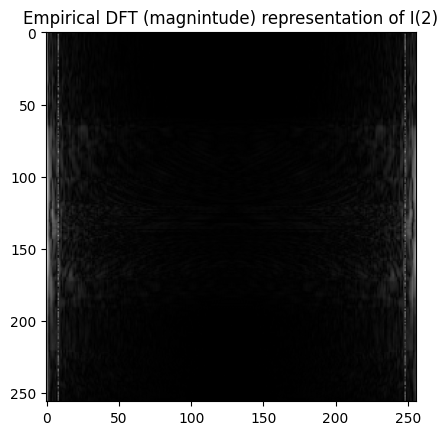

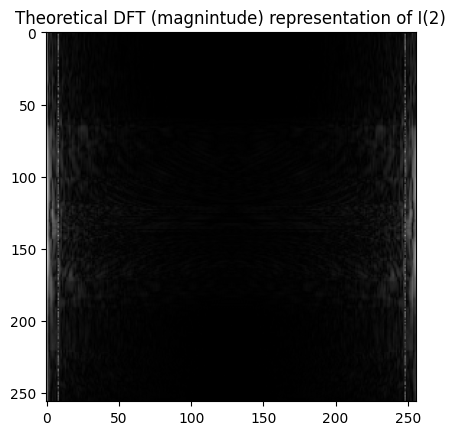

In [ ]:
original_image_dft = empiric_dft_transform(image_normalized)

I2_empirical = empiric_dft_transform(I_2)


I2_theory =  dft_theory_transform_image(original_image_dft, 1/32.0, A_2, phi_2)


show_image_dft(I2_empirical, "Empirical DFT (magnintude) representation of I(2)")
show_image_dft(I2_theory, "Theoretical DFT (magnintude) representation of I(2)")

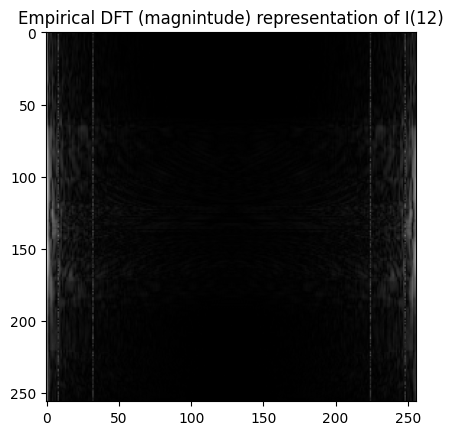

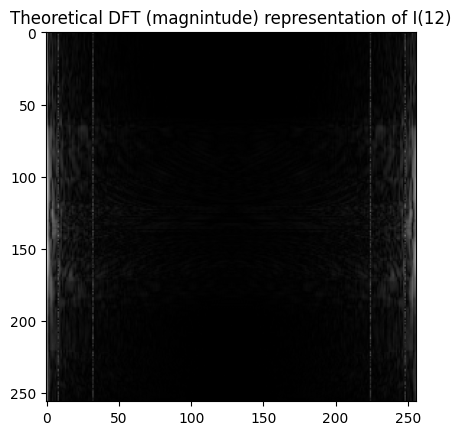

In [ ]:
original_image_dft = empiric_dft_transform(image_normalized)

I2_empirical = empiric_dft_transform(I_12)


I2_theory =  dft_theory_transform_image_weighted_average(original_image_dft, 1/8.0, 1/32.0, 0.5,0.5, A_1, phi_1,A_2, phi_2)


show_image_dft(I2_empirical, "Empirical DFT (magnintude) representation of I(12)")
show_image_dft(I2_theory, "Theoretical DFT (magnintude) representation of I(12)")

**e. Clean image**

In [ ]:
def apply_notch_filter(f_transform, noise_frequencies):
    n= f_transform.shape[0]
    filtered_transform = np.copy(f_transform)
    for freq in noise_frequencies:
        q = int(freq * n)
        filtered_transform[:,q % n] = 0
        filtered_transform[:,(n - q) % n] = 0
    return filtered_transform

def create_idft_matrix(N):
    k = np.arange(N).reshape((N, 1))
    l = np.arange(N).reshape((1, N))
    indices_matrix = k * l
    W = np.exp(2j * np.pi * indices_matrix / N)
    W /= np.sqrt(N)  # Normalize by sqrt(N) to make the matrix unitary
    return W

def empiric_idft_transform(image):
    assert(image.shape[0] == image.shape[1])
    N = image.shape[0]
    iDFT = create_idft_matrix(N)
    transformed = np.dot(image, iDFT)
    return  transformed

def fix_image(image, noise_frequencies):
    n = image.shape[0]
    dft_image = empiric_dft_transform(image)
    filtered_dft_matrix = apply_notch_filter(dft_image, noise_frequencies)
    reconstructed_image = empiric_idft_transform(filtered_dft_matrix)
    return np.abs(reconstructed_image)

def compute_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

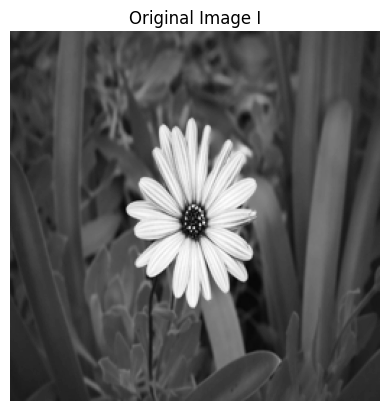

In [ ]:
show_image(image_normalized,"Original Image I")


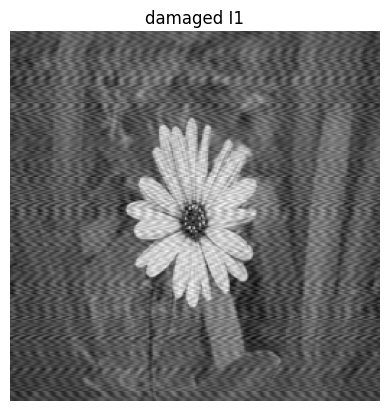

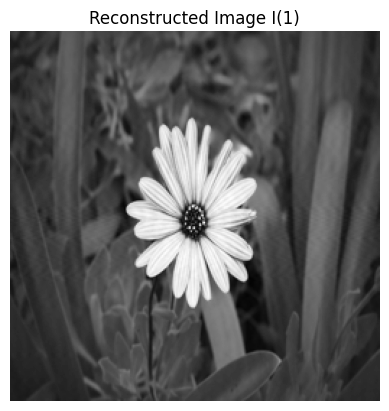

mse I1: 5.05101174972814e-05


In [ ]:
reconstructed_image_I1= fix_image(I_1, np.array([1/8.0]))
show_image(I_1, "damaged I1")
show_image(reconstructed_image_I1,"Reconstructed Image I(1)")
mse_i1 = compute_mse(image_normalized,reconstructed_image_I1)
print(f"mse I1: {mse_i1}")

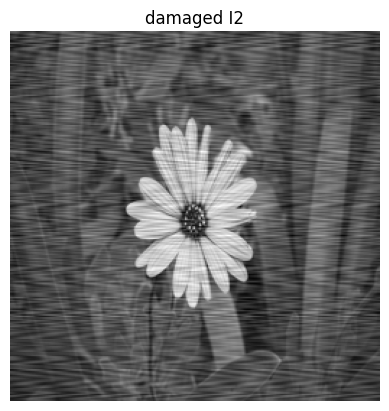

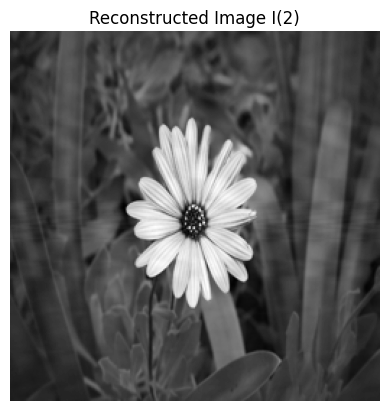

mse I2: 0.0006590660366675701


In [ ]:
reconstructed_image_I2= fix_image(I_2, np.array([1/32.0]))
show_image(I_2, "damaged I2")
show_image(np.abs(reconstructed_image_I2),"Reconstructed Image I(2)")
mse_i2 = compute_mse(image_normalized,reconstructed_image_I2)
print(f"mse I2: {mse_i2}")

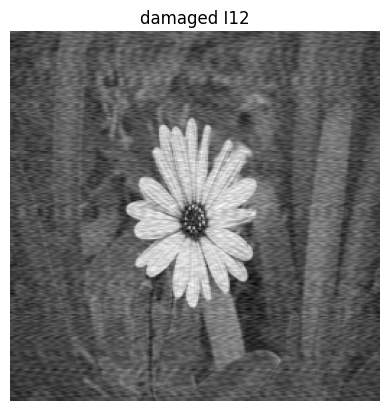

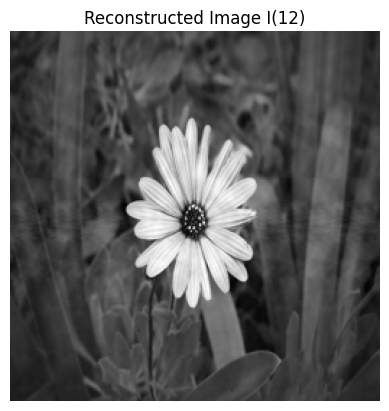

mse I12: 0.0007096245425748356


In [ ]:
reconstructed_image_I12= fix_image(I_12, np.array([1/8.0, 1/32.0]))
show_image(I_12, "damaged I12")
show_image(np.abs(reconstructed_image_I12),"Reconstructed Image I(12)")
mse_i12 = compute_mse(image_normalized,reconstructed_image_I12)
print(f"mse I12: {mse_i12}")